# Map 2D data

This notebook describes an algorithm for how to map 2D data using the (george package), which is based on Gaussian Process Regression  
[https://george.readthedocs.io/en/latest/]. 

Gaussian Processes (GP) are a supervised learning method designed to solve regression and probabilistic classification problems.

An introduction to GP regression can be found here: https://nbviewer.jupyter.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb




To test the function we choose to use temperature data from Argo floats similar to Kuessler and Stein (2018)  
https://doi.org/10.1098/rspa.2018.0400


The function will perform the following steps 
    
* Load a subset of Argo data using argopy
* Linearly interpolate onto pressure levels and select one pressure level for use
* Compute the mean state
* Subtract the mean state from the data to get the anomalies
* The GP is applied to the anomaly data



In [1]:
%matplotlib inline
import xarray as xr
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':14})

In [2]:
# Define region of interest to interpolate

ilat = -10
flat = 10
ilon = -130
flon = -110
idepth = 100
fdepth = 300
idate = "2010-01-01"
fdate = "2012-01-01"
ds = (
    ArgoDataFetcher()
    .region([ilon, flon, ilat, flat, idepth, fdepth, idate, fdate])
    .to_xarray()
)

In [3]:
argo_profiles = ds.argo.point2profile() # Convert points to profiles and 
argo_interp = argo_profiles.argo.interp_std_levels([250]) # Interpolate to pressure levels
selected_vars = argo_interp[["LATITUDE", "LONGITUDE", "TIME", "TEMP"]] #select relevant variables

In [4]:
selected_vars

<xarray.Dataset>
Dimensions:            (N_PROF: 3515, PRES_INTERPOLATED: 1)
Coordinates:
    LATITUDE           (N_PROF) float64 9.402 7.482 4.945 ... 7.804 -9.775 9.257
    LONGITUDE          (N_PROF) float64 -119.9 -124.2 -125.0 ... -126.7 -122.8
    TIME               (N_PROF) datetime64[ns] 2010-01-01T00:24:57 ... 2011-12-31T11:36:03
  * N_PROF             (N_PROF) int64 2854 2349 1786 2985 ... 2613 3523 2265
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 250
Data variables:
    TEMP               (N_PROF, PRES_INTERPOLATED) float64 10.74 10.71 ... 10.08
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           isabelle
    Fetched_date:         2020/08/14
    Fetched_constraints:  phy_[x=-130.00/-110.00; y=-10.00/10.00; z=100.0/300...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

In [4]:
# Compute the background mean

In [5]:
# Define some functions

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
from typing import Iterable


def get_harmonics(nharmonics, time, period=365):
    """Compute the requested number of harmonics
    for a set time.
    
    Parameters
    ----------
    nharmonics : int
        Number of harmonics to compute
    time : int, Iterable
        Time point within period of oscillation.
        This can be either a single int or a 1d-array
    period : int, optional
        Period of oscillation
        
    Returns
    -------
    harmonics: 2d-array
        Array of shape (len(time), nharmonics*2) where
        nharmonics*2 accounts for the cos and sin terms.
    """
    harmonics = np.arange(1, nharmonics + 1)
    if isinstance(time, Iterable):
        time = np.asarray(time)[:, np.newaxis]
        harmonics = harmonics[np.newaxis, :]
    phase = 2 * np.pi * harmonics * time / period
    return np.concatenate([np.cos(phase), np.sin(phase)], axis=-1)


def build_basis(lat, lon, time, nharmonics):
    """Build the 2d local polynomial regression basis
    according to Park2020
    """
    local_polynomlial_reg = np.ones((lat.size, 6 + nharmonics * 2))
    local_polynomlial_reg[:, 1] = lon
    local_polynomlial_reg[:, 2] = lat
    local_polynomlial_reg[:, 3] = lon * lat
    local_polynomlial_reg[:, 4] = lon ** 2
    local_polynomlial_reg[:, 5] = lat ** 2
    local_polynomlial_reg[:, 6:] = get_harmonics(nharmonics, time)
    return local_polynomlial_reg


def find_mean_state(lat, lon, time, data, nharmonics=2):
    """Find the mean state
    
    Parameters
    ----------
    lat, lon, time, data : 1d-array
        Arrays containing latitude, longitude, day of year and
        data.
    nharmonics: int, optional
        Number of harmonics to add into the basis functions
    """
    return lsq_linear(build_basis(lat, lon, time, nharmonics), data)

In [6]:
Taxis = np.zeros(len(selected_vars.TIME.values))
Taxis = selected_vars.TIME.values.astype(np.int64)/1e9/24/3600
Taxis # this gives number of days since 1970

array([14610.01732639, 14610.37552083, 14610.63574074, ...,
       15339.29232639, 15339.38443287, 15339.48336806])

In [7]:
14610/360

40.583333333333336

In [8]:
# Fit the mean

# We solve for the parameters mean state by solving a least squares problem,
# Ax=b , where A is the basis vectors, x are its parameters and b is the mean state+ anomalies
mean_state_fit = find_mean_state(
    selected_vars.LATITUDE,
    selected_vars.LONGITUDE,
    # selected_vars.TIME.dt.dayofyear, # this will not work because it will make the time in each year to be the same
    Taxis,
    selected_vars.TEMP.data.flatten(),
)

# now we predict the mean state (essentially only the part of the data that is mean, discarding the anomalies - which will be modeled by the GP lates)
mean_state = np.matmul(build_basis(selected_vars.LATITUDE, selected_vars.LONGITUDE, Taxis, 2), mean_state_fit.x)



In [9]:
# Get the anomaly
Anomaly = selected_vars.TEMP.squeeze() - mean_state


In [8]:
# Add plot here (world map? )

Text(0.5, 0, 'Longitude')

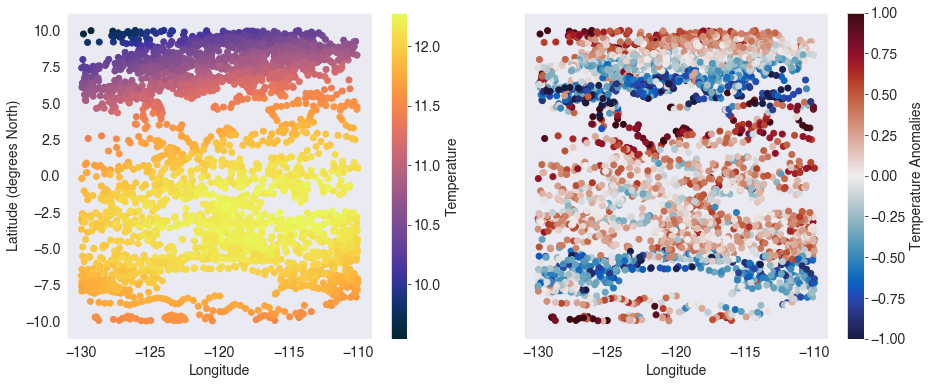

In [10]:
# Plot
# This plot has all the data, not just the data at certain time (so it mixes seasonal changes etc)

import cmocean.cm as cmo

fig, ax = plt.subplots(1,2, figsize=[15,6],sharey=True)
cs1 = ax[0].scatter(selected_vars.LONGITUDE,selected_vars.LATITUDE,c=mean_state, cmap=cmo.thermal)

cbar=plt.colorbar(cs1,ax=ax[0])
cbar.set_label('Temperature')


cs2 = ax[1].scatter( selected_vars.LONGITUDE,selected_vars.LATITUDE,c=Anomaly, cmap=cmo.balance, vmin=-1, vmax=1)
cbar=plt.colorbar(cs2,ax=ax[1])
cbar.set_label('Temperature Anomalies')

ax[0].set_ylabel('Latitude (degrees North)')

ax[0].set_xlabel('Longitude')
ax[1].set_xlabel('Longitude')


        

Text(0, 0.5, 'Mean temp')

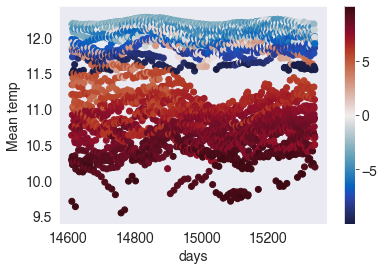

In [11]:
plt.scatter(Taxis, mean_state, c=selected_vars.LATITUDE, cmap=cmo.balance)
plt.colorbar()

plt.xlabel('days')
plt.ylabel('Mean temp')

# Check if the mean has some seasonal cycle

In [12]:
# Also make some predictions on a regular grid (for ease of plotting)

lat = np.linspace(ilat, flat, 60) # can change that 50 if you want predictions at finer scales
lon = np.linspace(ilon, flon, 50)

llon, llat = np.meshgrid(lon, lat)

# we need reshape the above into single column vectors, because that is expected. 
llons = llon.reshape(-1)
llats = llat.reshape(-1)

mean_state_s = np.matmul(build_basis(llats, llons, (2011-1970)*365, 2), mean_state_fit.x)
# chose a particular time to get a prediction at a certain time
# all the above thing does is Ax, which gives us b - the mean state. 
# you could also use the above matrix multiply to generate a time series at a location. 

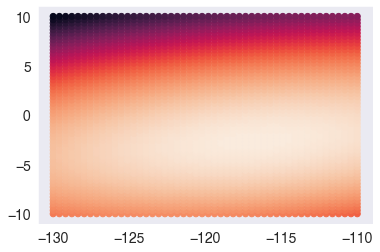

In [13]:
plt.scatter(llons, llats, c= mean_state_s.T)

In [14]:
# Could also regrid 
# we can regrid and create this 2D array 
# we know the size is 50X50, because that is what we chose above.
mean_state_g = mean_state_s.reshape(60,50)

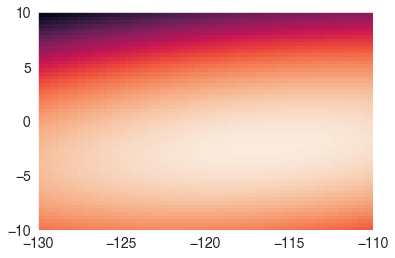

In [15]:
plt.pcolormesh(llon, llat, mean_state_g)

In [16]:
xmean_state = xr.DataArray(mean_state_g, dims= ["lat","lon"],coords=[ lat,lon])

In [17]:
xmean_state

<xarray.DataArray (lat: 60, lon: 50)>
array([[11.4394775 , 11.45129268, 11.46248021, ..., 11.31631079,
        11.29862684, 11.28031525],
       [11.48957094, 11.50176575, 11.51333292, ..., 11.38424727,
        11.36694296, 11.34901101],
       [11.53676961, 11.54934407, 11.56129088, ..., 11.449289  ,
        11.43236433, 11.41481202],
       ...,
       [ 9.67477517,  9.70822979,  9.74105676, ..., 10.5686623 ,
        10.5726178 , 10.57594565],
       [ 9.5598676 ,  9.59370186,  9.62690848, ..., 10.47159779,
        10.47593292, 10.47964041],
       [ 9.44206528,  9.47627918,  9.50986543, ..., 10.37163851,
        10.37635329, 10.38044042]])
Coordinates:
  * lat      (lat) float64 -10.0 -9.661 -9.322 -8.983 ... 8.983 9.322 9.661 10.0
  * lon      (lon) float64 -130.0 -129.6 -129.2 -128.8 ... -110.8 -110.4 -110.0

In [10]:
# Now we have the anomaly data that the GP will be computed on


In [20]:
import pandas as pd

# The lon,lat,time coordinates need to be in a specific format for george

Input_coordinates=xr.concat((selected_vars.LONGITUDE,selected_vars.LATITUDE,selected_vars.TIME.dt.dayofyear),pd.Index(['lon','lat','time'], name="coordinate")).T

In [21]:
Input_coordinates[:,2]

<xarray.DataArray 'LONGITUDE' (N_PROF: 3515)>
array([  1.,   1.,   1., ..., 365., 365., 365.])
Coordinates:
    TIME        (N_PROF) datetime64[ns] 2010-01-01T00:24:57 ... 2011-12-31T11:36:03
    LONGITUDE   (N_PROF) float64 -119.9 -124.2 -125.0 ... -123.1 -126.7 -122.8
    LATITUDE    (N_PROF) float64 9.402 7.482 4.945 2.113 ... 7.804 -9.775 9.257
  * N_PROF      (N_PROF) int64 2854 2349 1786 2985 524 ... 2511 2613 3523 2265
    coordinate  <U4 'time'

In [22]:
import george as grg

Choose a kernel (covariance) function to model these data, assume a zero mean model

In [23]:
# Define lengthscale

Lxscale = 110e3*np.sin(2*np.pi/360*50)
Lyscale = 110e3

#test larger length scales
Lxscale = 180e3*np.sin(2*np.pi/360*50)
Lyscale = 180e3

# Define kernel (covariance function)
# A simple exponential squared kernel is used, assuming isentropy. 
# There are a number of kernels that can be used

kernel_argo = np.var(Anomaly).values*grg.kernels.ExpSquaredKernel([100e3**2/Lxscale**2, 
                                                100e3**2/Lyscale**2, 
                                                30**2
                                               ], ndim=3)

In [24]:
# Now let us set up the GP. 

gp_argo = grg.GP(kernel_argo)

In [25]:
gp_argo.compute(Input_coordinates, 0.01) # 0.01 is an estimated observational error/ noise

In [33]:
# Define some test grid points

#test_pts_argo = np.array(np.meshgrid(np.linspace(-130,-116,30), 
#                       np.linspace(-10,10,30),
#                        np.linspace(0,365,30))).reshape(3,-1).T

test_pts_argo = np.array(np.meshgrid(np.linspace(-130,-116,30),    # only one time value - speeds up the optimisation
                       np.linspace(-10,10,30),
                        150.0)).reshape(3,-1).T

test_pts_argo = xr.DataArray(test_pts_argo,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo.shape[0]), ['lon','lat','time']] ) 

In [34]:
pred_argo, pred_var_argo = gp_argo.predict(Anomaly, test_pts_argo, return_var=True)
# Here the parameters introduced initially are used. No optimization is done. 
# This is the posterior distribution, where the hyper parameters were manually chosen. 
pred_argo = xr.DataArray(pred_argo,  dims={"test_pt_num"})
pred_var_argo = xr.DataArray(pred_var_argo,  dims={"test_pt_num"})

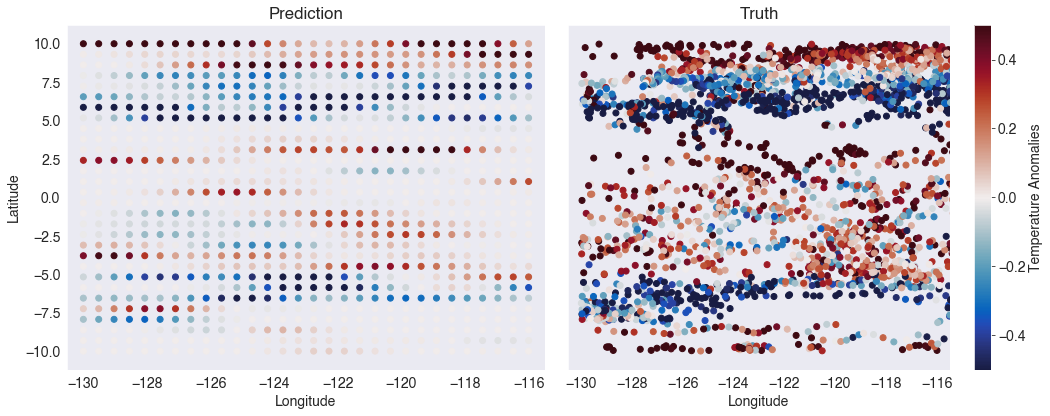

In [35]:
fig,ax=plt.subplots(1,2,figsize=(15,6),sharex=True,sharey=True)


cs=ax[0].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
#plt.colorbar(cs,ax=ax[0])
ax[0].set_title('Prediction')

ax[0].set_xlim(-130.5,-115.5)

x_sel = Input_coordinates
y_sel = Anomaly

cs2=ax[1].scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[1].set_xlabel('Longitude')

cbar=plt.colorbar(cs2,ax=ax[1])
cbar.set_label('Temperature Anomalies')
ax[1].set_title('Truth')

plt.tight_layout()

In [36]:
# Compute the Maximum Likelihood

print("Initial ln-likelihood: {0:.2f}".format(gp_argo.log_likelihood(Anomaly)))

Initial ln-likelihood: -1743.36


Use Scipys optimize function to fit the maximun likelihood parameters 

In [37]:
from scipy.optimize import minimize


def neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.log_likelihood(Anomaly)

def grad_neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.grad_log_likelihood(Anomaly)

# these functions could probably be written better, and not be so hard coded,
# needed to change the insides because things were named with "_argo" here.

In [38]:
%time result_argo = minimize(neg_ln_like_argo,gp_argo.get_parameter_vector(), jac=grad_neg_ln_like_argo)

CPU times: user 6min 59s, sys: 8.03 s, total: 7min 7s
Wall time: 2min 13s


In [39]:
# Optimized likelihood

gp_argo.set_parameter_vector(result_argo.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp_argo.log_likelihood(Anomaly)))



Final ln-likelihood: -1743.36


In [40]:
# Here the new prediction is made using the MLE parameter estimates

pred_MLE_argo, pred_var_MLE_argo = gp_argo.predict(Anomaly, test_pts_argo, return_var=True)
pred_MLE_argo = xr.DataArray(pred_MLE_argo,  dims={"test_pt_num"})
pred_var_MLE_argo = xr.DataArray(pred_var_MLE_argo,  dims={"test_pt_num"})

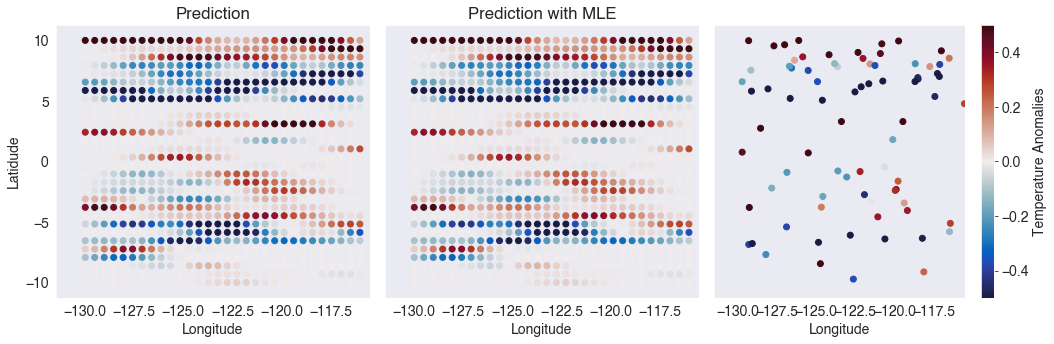

In [66]:
fig,ax= plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)


cs=ax[0].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latidude')
ax[0].set_title('Prediction')

cs2=ax[1].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_MLE_argo, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[1].set_xlabel('Longitude')
ax[1].set_title('Prediction with MLE')


x_sel = Input_coordinates.where(np.logical_and(Input_coordinates.sel(coordinate='time')<155.0 , 
                               Input_coordinates.sel(coordinate='time')>145.0), 
                                drop='true')

y_sel = Anomaly.where(np.logical_and(Input_coordinates.sel(coordinate='time')<155.0 , 
                               Input_coordinates.sel(coordinate='time')>145.0), 
                                drop='true')

#plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
#            c=y_sel, cmap='RdBu_r')

#plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
#            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')


cs=ax[2].scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap=cmo.balance)

ax[2].set_xlabel('Longitude')
cbar=plt.colorbar(cs,ax=ax[2])
cbar.set_label('Temperature Anomalies')
ax[2].set_label('Truth')
ax[2].set_xlim(-131.5, -115.5)

plt.tight_layout()



In [61]:
# Did the MLE change the length scales that we had guessed?
print(gp_argo.parameter_names)
print(np.exp(gp_argo.parameter_vector))

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0', 'kernel:k2:metric:log_M_1_1', 'kernel:k2:metric:log_M_2_2')
[1.00000000e+00 1.25000000e-12 6.65156372e-02 1.36411249e+00
 1.73636226e-02 1.09416294e+02]


In [62]:
print('Lx(km)='+str((np.exp(gp_argo.parameter_vector[3])*Lxscale**2)**0.5/1e3))
print('Ly(km)='+str((np.exp(gp_argo.parameter_vector[4])*Lyscale**2)**0.5/1e3))
print('Timescale(km)='+str((np.exp(gp_argo.parameter_vector[5]))**0.5))

# These are sensible numbers
# Notice that the method has made the Lx > Ly, and also shrunk the timescale a bit.

Lx(km)=161.04660139568958
Ly(km)=23.718797854625702
Timescale(km)=10.460224355377088


In [78]:
# What about a time series prediction.

test_pts_argo2 = np.array(np.meshgrid(np.linspace(-130,-116,30),    # selected lat = 0
                       7,
                        np.linspace(0,365,30))).reshape(3,-1).T




In [79]:
test_pts_argo2 = xr.DataArray(test_pts_argo2,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo.shape[0]), ['lon','lat','time']] ) 

In [81]:
pred_MLE_argo2, pred_var_MLE_argo2 = gp_argo.predict(Anomaly, test_pts_argo2, return_var=True)
# Here the new prediction is made using the MLE parameter estimates.
pred_MLE_argo2 = xr.DataArray(pred_MLE_argo2,  dims={"test_pt_num"})
pred_var_MLE_argo2 = xr.DataArray(pred_var_MLE_argo2,  dims={"test_pt_num"})

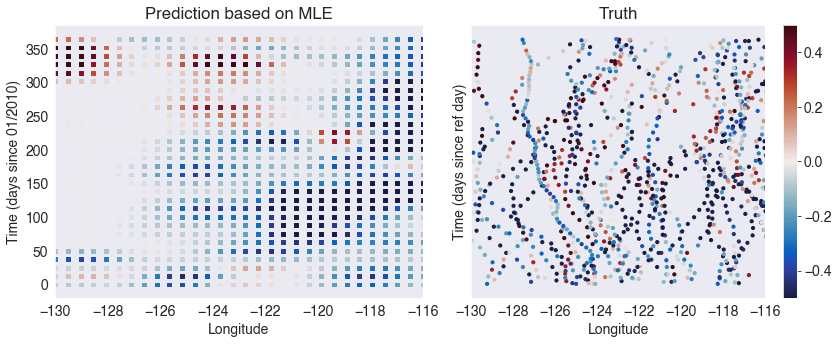

In [97]:
fig,ax= plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)


cs=ax[0].scatter(test_pts_argo2.sel(coordinate='lon'), 
            test_pts_argo2.sel(coordinate='time') , 
            c=pred_MLE_argo2, vmin=-.5, vmax=.5, s=15, marker='s', cmap=cmo.balance)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Time (days since 01/2010)')
ax[0].set_title('Prediction based on MLE')




x_sel = Input_coordinates.where(np.logical_and(
                                Input_coordinates.sel(coordinate='lat')<9, 
                                Input_coordinates.sel(coordinate='lat')>4), 
                                drop='true')

y_sel = Anomaly.where(np.logical_and(
                                Input_coordinates.sel(coordinate='lat')<9, 
                                Input_coordinates.sel(coordinate='lat')>4), 
                                drop='true')


cs=ax[1].scatter(x_sel.sel(coordinate='lon'), 
            x_sel.sel(coordinate='time'), 
            c=y_sel, vmin=-.5, vmax=.5, s=10, cmap=cmo.balance)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Time (days since ref day)')
plt.colorbar(cs,ax=ax[1])
ax[1].set_title('Truth')
ax[1].set_xlim([-130, -116])
#plt.ylim([2013, 2019])

plt.tight_layout()

# Can see the seasonal cycle

Text(0.5, 1.0, 'Prediction based on MLE')

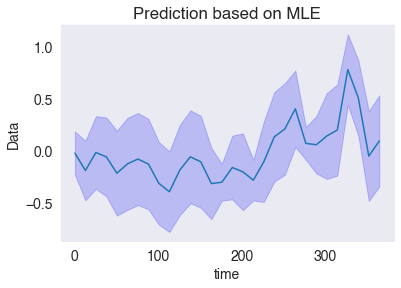

In [113]:
# This isnt right yet

x_sel = test_pts_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')>-124.1, 
                                test_pts_argo2.sel(coordinate='lon')<-123.5), 
                                drop='true')
y_sel = pred_MLE_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')>-124.1, 
                                test_pts_argo2.sel(coordinate='lon')<-123.5), 
                                drop='true')
y_var = pred_var_MLE_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')>-124.1, 
                                test_pts_argo2.sel(coordinate='lon')<-123.5), 
                                drop='true')

plt.fill_between(x_sel.sel(coordinate='time'), 
                 y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="b", alpha=0.2)
plt.plot(x_sel.sel(coordinate='time'), y_sel)

plt.ylabel('Data')
plt.xlabel('time')

plt.title('Prediction based on MLE')

# The prediction of the time series is relatively poor,
# but considering the limited amount of data it is probably not bad. (Only one year)